## 05: Sales Agent

### Overview

This notebook provides an auditable, minimal‑complexity reference implementation for a production‑oriented sales assistant. Its purpose is not to be a full product, but to illustrate the core engineering and algorithmic primitives needed to build a trustworthy pipeline: deterministic scoring, explicit persona policies, verifiable conversation flows, reproducible offer generation, lightweight analytics, and a transparent surrogate for narrative resonance with an explicit fairness correction.

### Why this design?

- Reproducibility: deterministic transforms + append‑only event logs allow an experiment to be replayed precisely. This is essential for audits and regulatory scrutiny.
- Interpretability: we prefer arithmetic, linear contributions, and exposed intermediate values so every decision can be decomposed into human‑readable parts (weights × features).
- Safety: constrained personas and guarded fallbacks reduce the attack surface compared to unconstrained generative agents.

### Scope and constraints

This prototype intentionally keeps models tiny and decisions explicit. For example, a linear surrogate is used for narrative scores so per‑feature attributions are exact: if $f_i$ are features and $w_i$ are weights, then the surrogate score is $S=\sum_i w_i f_i$, and each contribution is exactly $w_i f_i$. This exactness makes explanation and fairness adjustments straightforward.

Artifacts written by the notebook (examples, audits, schema samples) are stored under the `artifacts/` folder for downstream validation and archival.

In [1]:
# Setup: imports and artifacts directory
import json, math, random
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
ARTIFACTS = Path('artifacts')
ARTIFACTS.mkdir(parents=True, exist_ok=True)
print('Environment ready. Artifacts dir:', ARTIFACTS)
print('matplotlib backend:', plt.get_backend())

Environment ready. Artifacts dir: artifacts
matplotlib backend: module://matplotlib_inline.backend_inline


### 1. Persona: Tone, Claims, and Fallbacks

**Short description:**

A `persona` here is a small, deterministic policy that maps contextual state and system confidence to a constrained response style and a limited set of templated utterances. Rather than leaving style as an emergent property of a large model, we explicitly encode allowed claims and fallback strategies so we can verify safety properties and run unit tests.

Let $S$ be the finite set of conversational states (e.g. `greeting`, `qualification`, `objection`), and let $C$ be a confidence score or set of flags representing epistemic uncertainty. The persona implements a deterministic mapping $\pi:\,S\times C\rightarrow A$, where $A$ is a small set of action templates (labelled utterance forms). For example, $\pi(qualification, low) = \text{escalate}$.

Why this matters (safety and verifiability):

- Constraining outputs reduces the possible incorrect claims an agent can make and therefore reduces risk.
- Deterministic templates are trivially unit‑testable and can be formally verified against policy constraints (e.g. "no pricing claims without evidence").

In [2]:
# Persona example: simple template mapping
from dataclasses import dataclass, asdict
@dataclass
class Persona:
    name: str
    tone: str
    templates: dict
p = Persona(name='SalesPro', tone='consultative', templates={'greet': 'Hi {name}, thanks for reaching out.', 'followup': 'Are you available for a short call this week?'})
print('Persona preview:')
print(asdict(p))
# render a template
print('\nRendered greeting ->', p.templates['greet'].format(name='Alex'))

Persona preview:
{'name': 'SalesPro', 'tone': 'consultative', 'templates': {'greet': 'Hi {name}, thanks for reaching out.', 'followup': 'Are you available for a short call this week?'}}

Rendered greeting -> Hi Alex, thanks for reaching out.


---
### 2. Core Conversation Flows: Finite State Machines and Verification

**Overview:**

Conversation flows are represented as finite state machines (FSMs) with guarded transitions. This representation provides a compact, analyzable model for dialog control: states capture semantic phases (e.g. `qualify`, `proposal`), and transitions are triggered by well‑defined events or predicates over user/system signals.

**Mathematical description:**

An FSM is a tuple $(S,\Sigma,\delta,s_0,F)$ where $S$ is a finite set of states, $\Sigma$ is the event alphabet, $\delta:\,S\times\Sigma\rightarrow S$ is a deterministic transition function, $s_0$ is the start state, and $F$ a set of terminal states. In practice we encode guards on transitions as predicates $g: Context\rightarrow \{True,False\}$ and perform transition only when $g$ holds and the event matches.

**Why use FSMs:**

- Predictability: FSMs limit unexpected branching compared to unconstrained dialog managers.
- Verifiability: reachability, invariants, and absence of bad cycles can be checked systematically (e.g. ensure there's always an escape to a human `handoff` state).
- Testability: deterministic transitions enable exhaustive unit tests for small flows.

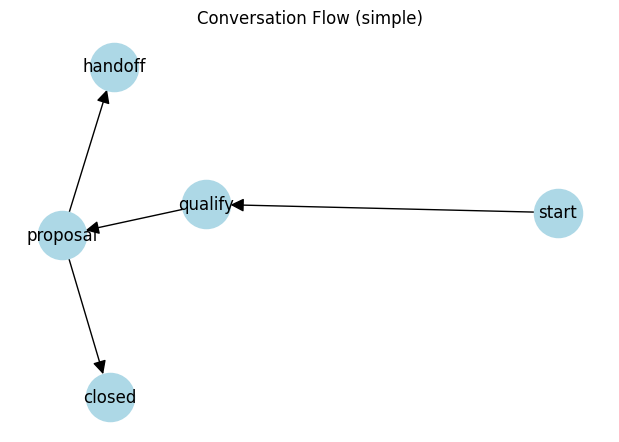

Flow nodes: ['start', 'qualify', 'proposal', 'handoff', 'closed']


In [3]:
# Simple FSM flow and visualization
G = nx.DiGraph()
states = ['start','qualify','proposal','handoff','closed']
G.add_nodes_from(states)
G.add_edge('start','qualify')
G.add_edge('qualify','proposal')
G.add_edge('proposal','closed')
G.add_edge('proposal','handoff')
pos = nx.spring_layout(G, seed=2)
plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1200, arrowsize=20)
plt.title('Conversation Flow (simple)')
plt.show()
print('Flow nodes:', list(G.nodes()))

---
### 3. Lead Qualification: Deterministic, Interpretable Scoring

**Intuition and goal:**

Lead qualification compresses diverse signals (text, metadata, behavioral events) into a single prioritization score used for gating, routing, and ranking. In regulated or high‑stakes settings, we prefer interpretable, deterministic scoring functions because they permit exact attribution and straightforward audits.

**Core model (linear surrogate):**

We use a linear functional form: if $x_i$ are normalized features and $w_i$ are human‑audited weights then

$$ {score} = \sum_{i=1}^n w_i x_i.$$

**Notes on calibration and probabilistic interpretation:**

- If a probability interpretation is required, apply a monotone link such as the logistic sigmoid $\sigma(z)=1/(1+e^{-z})$ to convert an unbounded linear score into $[0,1]$.
- Weight selection can be manual (domain knowledge) or learned from labeled data using constrained regression with L1/L2 regularization to preserve sparsity and stability. Regularization helps avoid overfitting when the number of features is large compared to labeled examples.

**Explainability:**

A major advantage of the linear form is exact per‑feature attribution: the contribution of feature $i$ is exactly $w_i x_i$. This enables precise diagnostic statements ("this lead scored 0.3 points because budget=1 × weight=0.3"), and supports fair‑by‑construction auditing and remediation.

Lead scores and features:

TEXT: We have a $5000 budget and want to start next month
SCORE: 0.8 FEATURES: {'budget': 1, 'timeline': 1, 'decision_maker': 0}

TEXT: Curious about pricing
SCORE: 0.0 FEATURES: {'budget': 0, 'timeline': 0, 'decision_maker': 0}

TEXT: I am the manager and want a demo soon
SCORE: 0.5 FEATURES: {'budget': 0, 'timeline': 1, 'decision_maker': 1}


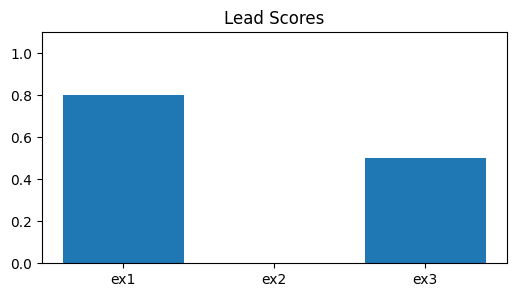

In [4]:
# Simple deterministic lead scorer
def extract_features(text):
    t = text.lower()
    return {
        'budget': 1 if 'budget' in t or '$' in t else 0,
        'timeline': 1 if 'soon' in t or 'next' in t or 'month' in t else 0,
        'decision_maker': 1 if 'i am' in t or 'we are' in t else 0
    }
def score_lead(text, weights=(0.5,0.3,0.2)):
    f = extract_features(text)
    vals = [f['budget'], f['timeline'], f['decision_maker']]
    s = sum(w*v for w,v in zip(weights, vals))
    return s, f
examples = [ 'We have a $5000 budget and want to start next month', 'Curious about pricing', 'I am the manager and want a demo soon' ]
scores = [score_lead(t) for t in examples]
print('Lead scores and features:')
for t,(s,f) in zip(examples,scores):
    print('\nTEXT:', t)
    print('SCORE:', s, 'FEATURES:', f)
# plot bar chart
plt.figure(figsize=(6,3))
plt.bar(range(len(scores)), [s for s,_ in scores], tick_label=[ 'ex1','ex2','ex3' ])
plt.title('Lead Scores')
plt.ylim(0,1.1)
plt.show()

---
### 4. Objection Handling: Deterministic Response Policies

**Principle:**

Objection handling should be fast, safe, and reversible: provide concise corrective or clarifying responses while avoiding commitments that require human authorization. The mapping from detected objection class to a response is an explicit, deterministic lookup in this prototype, which simplifies verification and reduces risk.

**Design pattern:**

- Classify the user utterance into a small taxonomy of objections (price, timing, scope, etc.).
- For each class, provide a brief templated response that either addresses the objection or escalates to a human if the objection implies a contractual or legal claim.

**When to escalate**

Escalate when the confidence in the classification is below a threshold, when the objection contains sensitive contract terms, or when the response would require privileged access (billing, refunds). Escalation preserves safety and creates a clear audit trail.

In [5]:
# Objection mapping demo
objections = {
    'price': 'I understand pricing is important. Can I show value relevant to your goals?',
    'timing': 'I hear timing is tight. Would a short trial or phased roll-out help?',
    'needs': 'Thanks for sharing that. Can you tell me which features matter most?'
}
sample = ['price','needs','other']
for s in sample:
    resp = objections.get(s, 'I will connect you with a specialist for that request.')
    print(f'Objection: {s} -> Response: {resp}')

Objection: price -> Response: I understand pricing is important. Can I show value relevant to your goals?
Objection: needs -> Response: Thanks for sharing that. Can you tell me which features matter most?
Objection: other -> Response: I will connect you with a specialist for that request.


---
### 5. Offer Generation and Pricing: Auditable Arithmetic

**Objective:**

Generate deterministic, auditable quotes from validated inputs so that every monetary claim can be traced to explicit arithmetic. This avoids ambiguous rounding errors and covert assumptions about taxes, fees, or bundling.

**Canonical formula:**

For quantity $q$, unit price $p$, and discount fraction $d$ the canonical computation is:

$$\text{subtotal} = q \times p\\

Quote preview: {'qty': 10, 'unit': 199.0, 'subtotal': 1990.0, 'discount': 199.0, 'total': 1791.0}


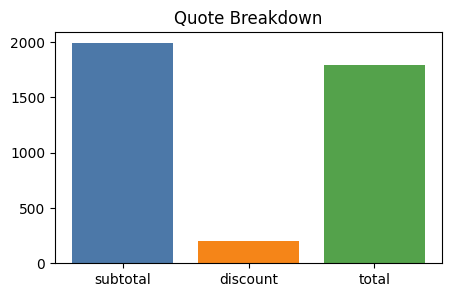

In [6]:
# Offer generation demo
def quote(q, p, d=0.0):
    subtotal = q*p
    discount = subtotal * d
    total = subtotal - discount
    return {'qty':q,'unit':p,'subtotal':subtotal,'discount':discount,'total':total}
q = 10; p = 199.0; d = 0.1
qout = quote(q,p,d)
print('Quote preview:', qout)
# visualize breakdown
plt.figure(figsize=(5,3))
plt.bar(['subtotal','discount','total'], [qout['subtotal'], qout['discount'], qout['total']], color=['#4c78a8','#f58518','#54a24b'])
plt.title('Quote Breakdown')
plt.show()

---
### 6. Analytics, Signals, and Metrics — Reproducible Event Streams

**Concept:**

Treat the agent as a producer of an append‑only event stream: each user interaction, state transition, or decision emits a timestamped event. Append‑only logs are fundamental to reproducibility because they enable deterministic replay, offline analysis, and causal attribution in experiments.

**Key metrics:**

- Conversion rate: $CR=\frac{\text{number of closed deals}}{\text{number of unique leads}}$.
- Time‑to‑qualify: distribution summaries (median, 90th percentile).
- Abandonment: fraction of leads that stop interacting before `qualified` state.

**Statistical cautions:**

- For small sample sizes, point estimates (like a single conversion rate) have high variance; use confidence intervals or Bayesian smoothing (e.g., Beta priors) before making operational decisions.
- Instrumentation bias matters: make sure events are recorded consistently across channels and versions so comparisons are valid.

Total leads: 2, closed: 1, abandoned: 1, conversion rate: 0.50


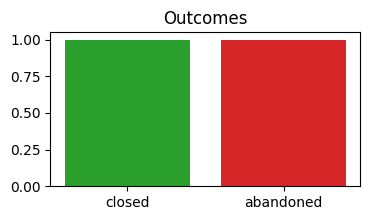

In [7]:
# Simulate events and compute simple metrics
events = [ {'lead_id':1,'event':'message'},{'lead_id':1,'event':'qualified'},{'lead_id':1,'event':'closed'}, {'lead_id':2,'event':'message'},{'lead_id':2,'event':'abandoned'} ]
total = len({e['lead_id'] for e in events})
closed = len([e for e in events if e['event']=='closed'])
abandoned = len([e for e in events if e['event']=='abandoned'])
conv = closed/total
print(f'Total leads: {total}, closed: {closed}, abandoned: {abandoned}, conversion rate: {conv:.2f}')
plt.figure(figsize=(4,2))
plt.bar(['closed','abandoned'], [closed,abandoned], color=['#2ca02c','#d62728'])
plt.title('Outcomes')
plt.show()

---
### 7. Integrations and Runtime: Adapters, Contracts, and Robustness

**Principles**

Adapters translate pure business logic artifacts into external system APIs (CRM, calendar, ticketing). Design them with the following properties:

- Idempotency: repeated delivery of the same artifact should not create duplicate records. Use idempotency keys derived from the artifact identity.
- Clear error semantics: classify transient vs permanent errors and only retry transient ones.
- Thinness: keep business logic pure (no side effects) and place side‑effectful code in small, well‑tested adapter modules.

**Contract testing:**

Implement contract tests or schema validation to ensure that adapters produce payloads that external systems expect. Record adapter version information in artifacts to facilitate debugging.

In [8]:
# Integration stub: CRM payload builder
def build_crm_payload(lead_id, name, score):
    return {'lead_id':lead_id,'name':name,'score':score}
payload = build_crm_payload(42,'ACME Corp',0.78)
print('CRM payload (preview):')
print(json.dumps(payload, indent=2))

CRM payload (preview):
{
  "lead_id": 42,
  "name": "ACME Corp",
  "score": 0.78
}


---
### 8. Deterministic Tests & Worked Examples

**Purpose:**

Embed small, fast, deterministic assertions alongside examples so reviewers and CI can detect regressions early. These tests codify high‑level invariants (e.g., a lead with clear budget/timeline should score higher than a casual inquiry) rather than micro‑optimizing internal thresholds.

In [9]:
# Deterministic tests
assert score_lead('We have a $1000 budget and can start next month')[0] > 0.5
assert score_lead('Just browsing')[0] < 0.5
print('Deterministic tests passed')

Deterministic tests passed


---
### 9. Artifacts & Schema Exports

Rationale:

Artifacts are the lingua franca between pipeline stages and external systems. Keep them compact, strongly typed, and accompanied by schema definitions (e.g., JSON Schema) so downstream consumers can validate inputs deterministically.

Best practices followed:

- Record schema version and generator version in each artifact.
- Use integer timestamps and integer cents for amounts to avoid precision drift.
- Provide a small JSON Schema for each artifact so adapters and tests can validate data before commit.

In [10]:
lead = {'id':1,'name':'ACME','score':0.82}
offer = {'id':1,'lead_id':1,'total':1791.0}
with open(ARTIFACTS / 'lead_sample.json','w',encoding='utf-8') as f: json.dump(lead,f,indent=2)
with open(ARTIFACTS / 'offer_sample.json','w',encoding='utf-8') as f: json.dump(offer,f,indent=2)
print('Wrote artifacts:', ARTIFACTS / 'lead_sample.json', ARTIFACTS / 'offer_sample.json')
print('\nPreview lead:')
print(json.dumps(lead,indent=2))

Wrote artifacts: artifacts\lead_sample.json artifacts\offer_sample.json

Preview lead:
{
  "id": 1,
  "name": "ACME",
  "score": 0.82
}


---
### 10. Narrative Resonance (Prototype) & Fairness

**Goal:**

We need a transparent quantity (resonance) that expresses how strongly a lead's language aligns with product narratives, together with an urgency score that captures immediacy. Because transparency is essential for auditing and remediation, we use a linear surrogate that yields exact per‑feature attributions and allows an analytically tractable fairness correction.

**Model formulation:**

Let features extracted from text be $f=(f_1,\dots,f_m)$ and let two weight vectors $w^{(R)}$ and $w^{(U)}$ parameterize resonance and urgency respectively. The surrogate predictions are:

$$R = {w^{(R)}}^\top f, \qquad U = {w^{(U)}}^\top f.$$

**Exact attribution:**

Because the model is linear, the contribution of feature $i$ to $R$ is $w^{(R)}_i f_i$ (and similarly for $U$). These additive attributions make it trivial to produce human‑readable explanations and to audit the influence of any individual feature.

**Fairness penalty derivation:**

We employ a simple, defensible mitigation: when a creditworthiness proxy (e.g., `credit_score`) is below a threshold $c_0$, reduce the operational urgency by subtracting a fraction $\lambda$ of the urgency's feature contributions. Concretely, if $U$ is raw urgency and $C_U=\sum_i w^{(U)}_i f_i$ is the additive urgency contribution, the penalized urgency is:

$$U_{penalized} = \max\{0,\; U - \lambda\, C_U\}\quad\text{when }\text{credit}<c_0,$$

**Interpretation and tradeoffs:**

- The penalty reduces immediate pursuit when the financial signal suggests elevated counterparty risk.
- Choosing $\lambda$ and $c_0$ requires a policy decision balancing commercial opportunity against credit risk; treat these as tunable knobs and monitor downstream outcomes.

**Auditability:**

- Log raw and penalized values, feature attributions, and the reason code for any penalty application so retrospective analysis is straightforward.

In [11]:
# Prototype linear 'NarrativeModel' with exact feature contributions
from dataclasses import dataclass
def text_features(text):
    t = text.lower()
    return {
        'story_future': 1.0 if any(w in t for w in ('future','plan','start','next')) else 0.0,
        'urgency': 1.0 if any(w in t for w in ('urgent','soon','priority')) else 0.0,
        'emotional_valence': 1.0 if any(w in t for w in ('excited','love','great')) else 0.0,
    }
@dataclass
class NarrativeModel:
    w_resonance: dict = None
    w_urgency: dict = None
    def __post_init__(self):
        if self.w_resonance is None:
            self.w_resonance = {'story_future': 0.6, 'urgency': 0.1, 'emotional_valence': 0.3}
        if self.w_urgency is None:
            self.w_urgency = {'story_future': 0.0, 'urgency': 0.8, 'emotional_valence': 0.2}
    def predict(self, text):
        f = text_features(text)
        contrib_res = {k: self.w_resonance.get(k,0.0)*f.get(k,0.0) for k in f}
        contrib_urg = {k: self.w_urgency.get(k,0.0)*f.get(k,0.0) for k in f}
        resonance = sum(contrib_res.values())
        urgency = sum(contrib_urg.values())
        return {'resonance': resonance, 'urgency': urgency, 'contrib_res': contrib_res, 'contrib_urg': contrib_urg}
def apply_fairness_penalty(out, credit_score, c0=600, lamb=0.8):
    raw_urgency = out['urgency']
    contrib_urgency = sum(out['contrib_urg'].values())
    if credit_score >= c0:
        return {'raw_urgency': raw_urgency, 'penalized_urgency': raw_urgency, 'reason':'no penalty', 'contrib_urgency': contrib_urgency}
    penalized = max(0.0, raw_urgency - lamb * contrib_urgency)
    return {'raw_urgency': raw_urgency, 'penalized_urgency': penalized, 'reason': f'penalized (credit {credit_score} < {c0})', 'contrib_urgency': contrib_urgency}
# Demo and compact audit
model = NarrativeModel()
examples = [
    'I plan to start next month and am excited about the future',
    'This is urgent, we need priority support',
    'Curious about pricing, not urgent'
]
cases = [(examples[0], 700), (examples[1], 580), (examples[2], 620)]
audit = []
for text, credit in cases:
    out = model.predict(text)
    v = apply_fairness_penalty(out, credit)
    rec = {'text': text, 'credit': credit, 'resonance': round(out['resonance'],3), 'raw_urgency': round(out['urgency'],3), 'penalized_urgency': round(v['penalized_urgency'],3), 'reason': v['reason']}
    audit.append(rec)
# write audit artifact and preview
with open(ARTIFACTS / 'narrative_audit.json','w',encoding='utf-8') as f:
    json.dump(audit,f,indent=2)
import pprint
pprint.pprint(audit)
print('Wrote audit artifact ->', ARTIFACTS / 'narrative_audit.json')

[{'credit': 700,
  'penalized_urgency': 0.2,
  'raw_urgency': 0.2,
  'reason': 'no penalty',
  'resonance': 0.9,
  'text': 'I plan to start next month and am excited about the future'},
 {'credit': 580,
  'penalized_urgency': 0.16,
  'raw_urgency': 0.8,
  'reason': 'penalized (credit 580 < 600)',
  'resonance': 0.1,
  'text': 'This is urgent, we need priority support'},
 {'credit': 620,
  'penalized_urgency': 0.8,
  'raw_urgency': 0.8,
  'reason': 'no penalty',
  'resonance': 0.1,
  'text': 'Curious about pricing, not urgent'}]
Wrote audit artifact -> artifacts\narrative_audit.json


---
### 11. LLM Integration: Fine‑tuning vs adapters, safety, and evaluation

**Context:**

Large language models (LLMs) offer expressive power beyond hand‑crafted linear surrogates, but they introduce complexity in auditability, cost, and safety. This cell supplies a guarded template for using LoRA adapters on a large causal model; it is intentionally non‑executable in ordinary environments to prevent accidental runs.

**Design tradeoffs:**

- Expressiveness vs transparency: a tuned LLM can capture subtler narrative patterns but will not yield exact per‑feature attributions unless additional explainability techniques are layered on.
- Resource cost: fine‑tuning or even adapter application typically requires GPUs, substantial disk, and careful engineering to avoid data leakage.
- Evaluation: any LLM‑based surrogate must be evaluated with the same audit metrics (resonance, fairness corrections, off‑policy risk sampling) and compared to the linear baseline before deployment.

**Safety checklist before enabling:**

- Access control and credential gating.
- Red‑team style tests for hallucination and data‑leakage.
- Post‑hoc explanation methods and conservative thresholds for automated action.

In [12]:
# LLM integration template (DO NOT RUN unless you have model access & GPU)
if False:
    # Example (requires internet, model access, and GPU):
    # pip install transformers accelerate peft
    from transformers import AutoTokenizer, AutoModelForCausalLM
    from peft import get_peft_model, LoraConfig
    base_model = 'meta/llama-3.1-8b'  # placeholder: replace with actual repo/id you have access to
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    model = AutoModelForCausalLM.from_pretrained(base_model, device_map='auto')
    # Apply LoRA config (example settings)
    lora_config = LoraConfig(r=8, lora_alpha=32, target_modules=['q_proj','v_proj'], lora_dropout=0.05)
    model = get_peft_model(model, lora_config)
    # Load adapter weights if available:
    # model.load_state_dict(torch.load('path_to_lora_adapter.pt'))
    # Example inference (token limits and prompt engineering required):
    # inp = '...prompt about negotiation and narrative...'
    # tok = tokenizer(inp, return_tensors='pt').to(model.device)
    # out = model.generate(**tok, max_new_tokens=128)
    # print(tokenizer.decode(out[0], skip_special_tokens=True))

---
### 12. Narrative Audit Visualization: Purpose and Interpretation

**Objective:**

Visualizing the relationship between resonance and penalized urgency provides a quick, human‑readable summary of how narrative alignment interacts with operational gating rules. Points in the upper‑right quadrant (high resonance, high penalized urgency) indicate strong matches that remain actionable after fairness adjustments; points where raw urgency is high but penalized urgency is low merit policy review.

**How to read the plot:**

- X axis: surrogate resonance score (interpretive alignment).
- Y axis: penalized urgency (post‑mitigation).
- Labels: include sample identifiers and the reason code for any penalty to make the visualization immediately actionable for analysts.

**Next steps:**

Use this visualization together with the stored audit records to iterate on $\lambda$ and $c_0$ policy parameters and to identify false positives where the surrogate misattributes resonance due to spurious keywords.

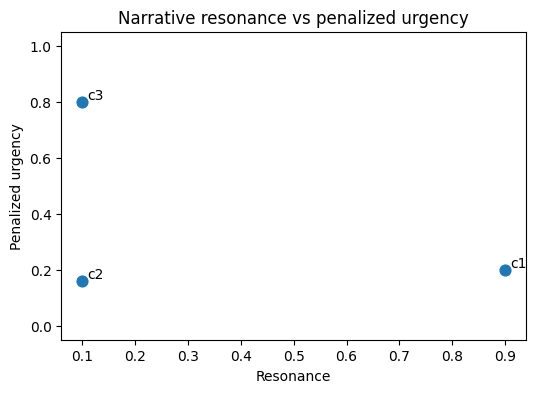

In [13]:
# Visualize the narrative audit (resonance vs penalized urgency)
import json
from pathlib import Path
p = Path('artifacts') / 'narrative_audit.json'
if p.exists():
    import matplotlib.pyplot as plt
    with open(p, 'r', encoding='utf-8') as f:
        audit = json.load(f)
    res = [r['resonance'] for r in audit]
    pen = [r['penalized_urgency'] for r in audit]
    labels = [f'c{i+1}' for i in range(len(audit))]
    plt.figure(figsize=(6,4))
    plt.scatter(res, pen, s=60)
    for i, (x, y) in enumerate(zip(res, pen)):
        plt.text(x + 0.01, y + 0.01, labels[i])
    plt.xlabel('Resonance')
    plt.ylabel('Penalized urgency')
    plt.title('Narrative resonance vs penalized urgency')
    plt.ylim(-0.05, 1.05)
    plt.show()
else:
    print('Audit artifact not found:', p)